In [9]:
import numpy as np
import pandas as pd
import statsmodels.api as smapi
import matplotlib.pyplot as plt

In [90]:
data = smapi.datasets.co2.load_pandas()
data

<class 'statsmodels.datasets.utils.Dataset'>

In [91]:
# 맞추고 싶은 것 자체니까 하나로 y에 담음.
y = data.data
y

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


In [92]:
y.info() # 2284개 중 2225개가 not null 이므로 나머지 결측치를 채워야 한다.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2284 entries, 1958-03-29 to 2001-12-29
Freq: W-SAT
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   co2     2225 non-null   float64
dtypes: float64(1)
memory usage: 35.7 KB


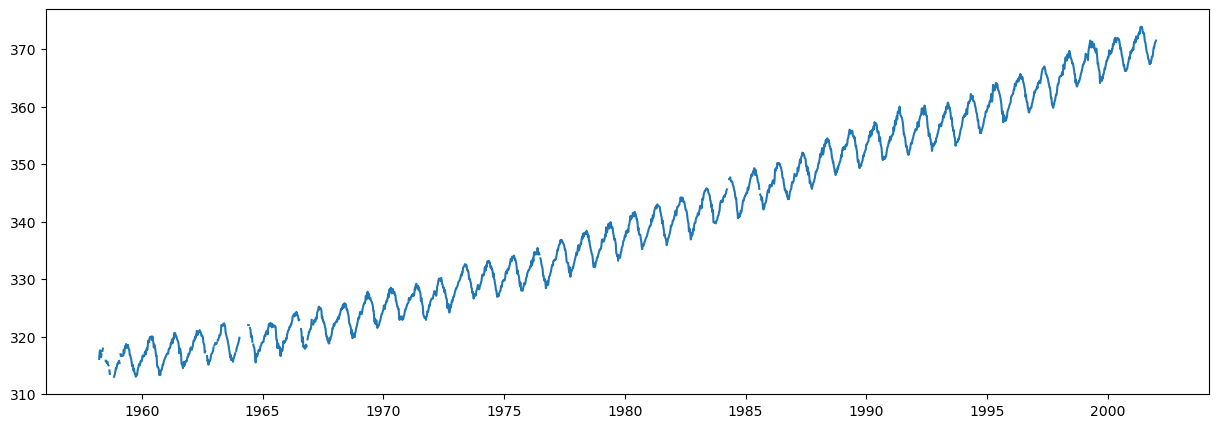

In [93]:
# 시계열 데이터에서 이후를 예측하기 위해서 어떤 모델을 사용할 지 알아본다. (과거의 상태/오차 중 어떤 것에 더 영향을 받는가?)

# 예측하기 전 우선 시계열 데이터를 다듬는다.
# 그래프 형태 알아본 뒤 결측치 채우기
plt.figure(figsize=(15, 5))
plt.plot(y['co2'])
plt.show()

<Axes: >

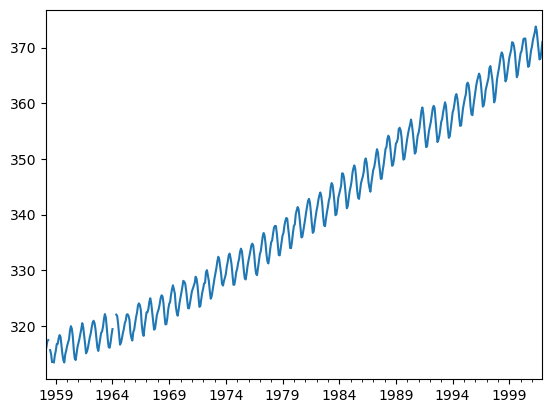

In [94]:
# 끊어진 곳이 군데군데 보인다. -> 보간해준다. (interpolate)
# drop시키면 결측치 이후의 값이 앞으로 당겨져서 시간축에 안 맞게 되므로 리샘플링으로 보간해준다.

# 한 주 동안의 평균을 내는 건데, 일주일 내내 결측치가 있다면 마찬가지로 결측치가 생긴다.
tmp = y['co2'].resample('W').mean() # Week

# 데이터의 상세한 부분은 포기하고 평균 낼 기간을 길게 잡아서 한 달 동안의 평균을 내어 준다.
tmp = y['co2'].resample('M').mean() # Month
tmp.plot()

<Axes: >

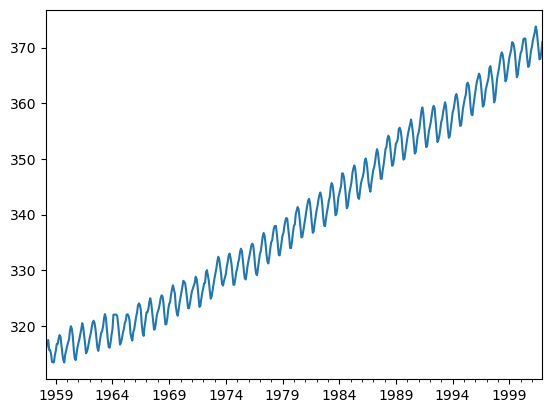

In [95]:
# 많이 메꾸어 졌으니 남은 빈 부분을 마저 채워준다.
y = tmp.bfill() # 결측치의 이후 값으로 채워준다.
y.plot()

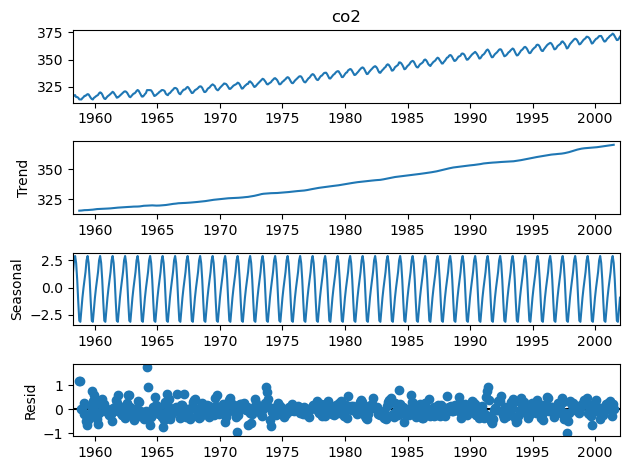

In [96]:
from statsmodels.tsa.seasonal import seasonal_decompose

# 잘 못 들었어..
# 트렌드나 계절성이 뚜렷하게 보인다.
# 잔여 오차: 3가지 그래프를 그리고 남은 0이나 1 같은 자잘한 알 수 없는 오차들이다?
result = seasonal_decompose(y, model='addictive') # 가법모형/승법모형 중 가법모형 씀.
result.plot()
plt.show()

C:\Users\PC\.conda\envs\CW_AI_Academy\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


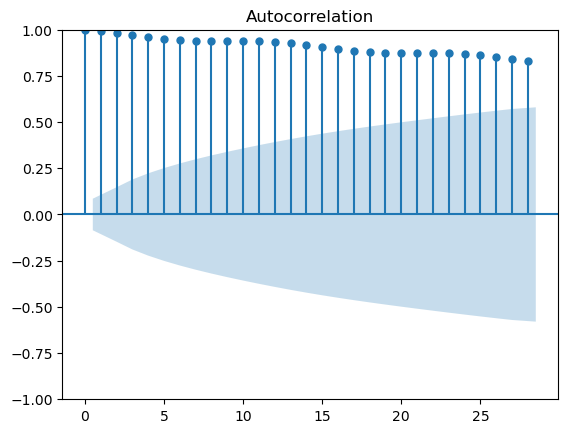

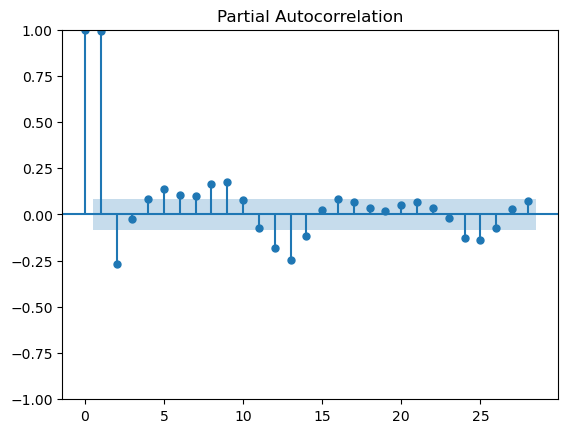

In [97]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(y)
plot_pacf(y)
plt.show()

### p <- pacf가 cut off 일어나기 직전 2 시차
### q <- acf가 점진적으로 감소하므로 0

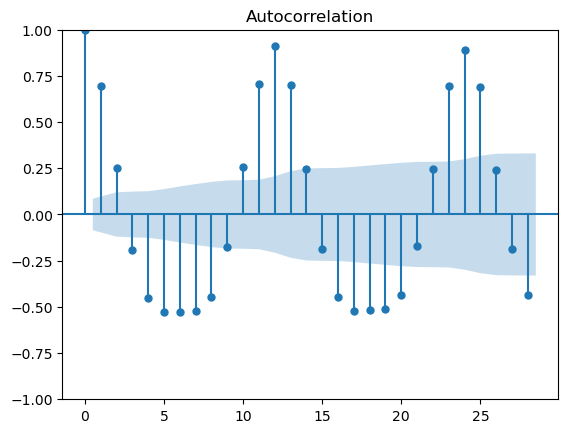

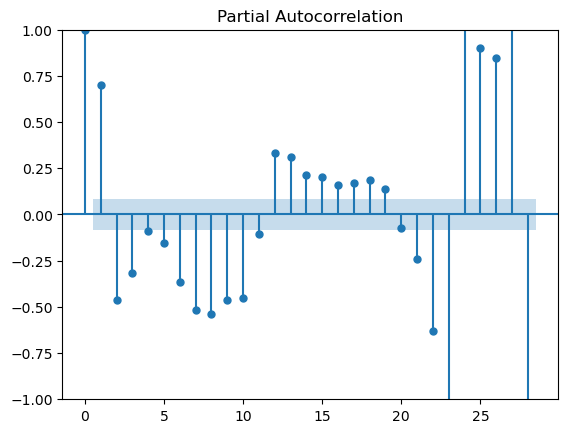

In [103]:
# 얼마나 차분할 지 구해야 한다.
y_diff = y.diff()[1:] # period=n: n차 차분. 기본적으로 1차 차분된다.

# sine 파형 모양으로 요동친다. 컷오프가 아니다. (지수적으로 감소 또는 소멸하는 sine함수 형태이므로)
# 둘 중 하나의 그래프는 컷오프 되어야 정상상태라고 부를 수 있다.
plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

<Axes: >

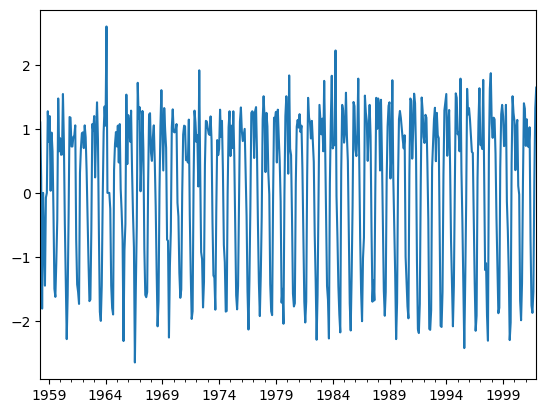

In [105]:
y_diff.plot() # 차분한 결과의 그래프

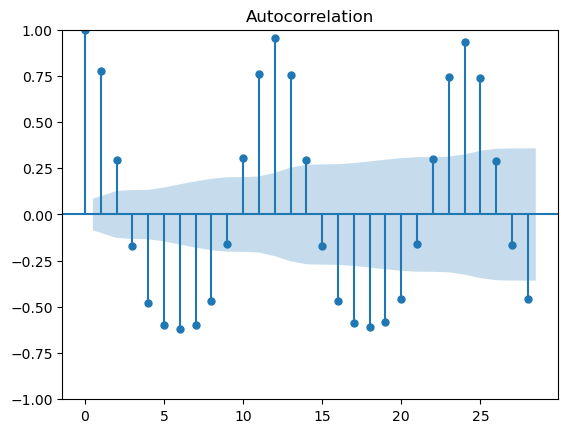

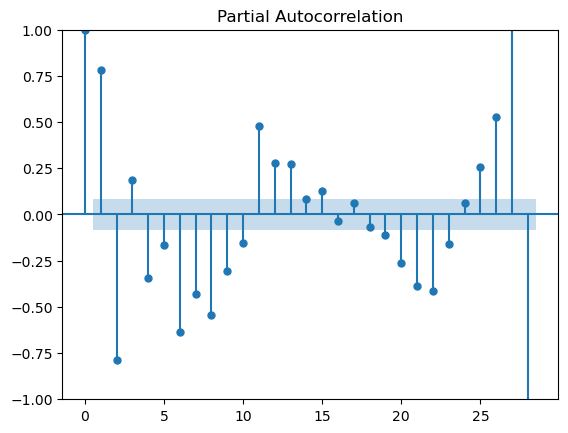

In [112]:
y_diff = y.diff(periods=2)[2:]

plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

### d <- 1차 차분으로 정상화 됨
### p, d, q = 2, 1, 0

In [119]:
# 모든 하이퍼파라미터가 정해졌으므로 ARIMA 모델을 본격적으로 사용해 본다.
from statsmodels.tsa.arima.model import ARIMA

# 장기적인 예측 모델로는 쓸 수 없다. 내일이나 다음 주 정도가 어떻게 될지. 그 이후는 알 수 없다.
arima = ARIMA(y, order=(2, 1, 0)) # p, d, q 순서로 튜플 형태로 넣어준다. p는 autoregressive, q는 movingaverage
arima_result = arima.fit()

In [121]:
arima_result.summary()

# AIC/BIC/HQIC: 모델 자체를 평가하는 지표. 작으면 작을수록 좋다.
# 두번째 표는 통계적으로 y가 어떻게 생겼는지 볼 수 있다.

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  526
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -599.722
Date:                Mon, 19 Jun 2023   AIC                           1205.443
Time:                        15:10:47   BIC                           1218.233
Sample:                    03-31-1958   HQIC                          1210.451
                         - 12-31-2001                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0224      0.044     23.454      0.000       0.937       1.108
ar.L2         -0.4589      0.043    -10.666      0.000      -0.543      -0.375
sigma2         0.5738      0.039     14.761      0.000       0.498       0.650
===================================================================================
Ljung-Box (L1) (Q):                  11.56   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.00   Prob(JB):                         0.58
Heteroskedasticity (H):               0.83   Skew:                             0.10
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

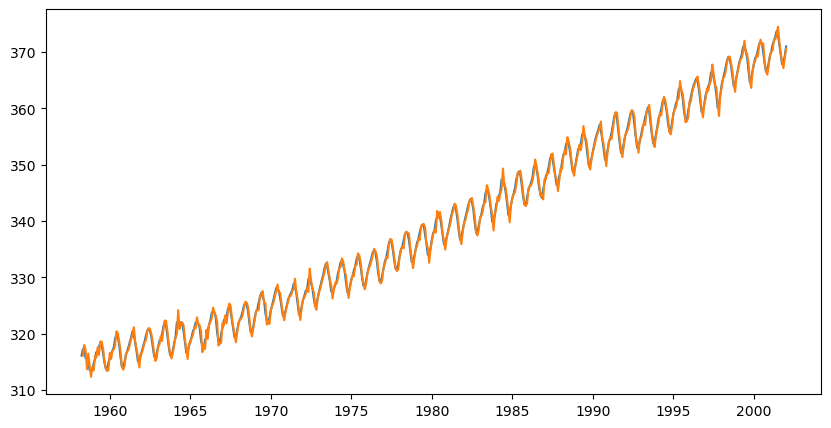

In [129]:
# AR부분이 날아간 두 개만의 항으로 어떻게 잘 표현이 됐는지 확인해 보자.
p = arima_result.predict()
plt.figure(figsize=(10, 5))
plt.plot(y) # 원래 값도 그래프에 그려 준다.
plt.plot(p[1:]) # 첫 번째 값이 없어서 이상하게 보인다. 잘라 준다.
plt.show()

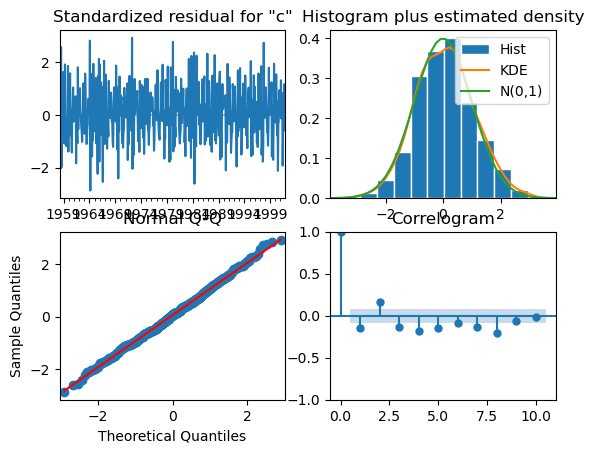

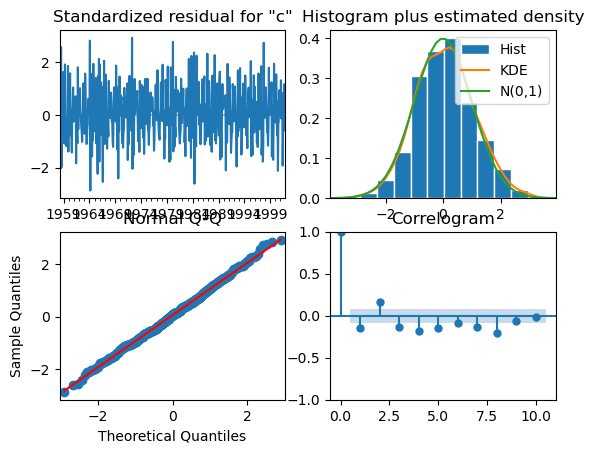

In [130]:
arima_result.plot_diagnostics()
# 잔여 오차가 화이트노이즈 백색소음.. 을 뺀것? 그모양이 나오면 fit이 잘 된거다.
# 첫번째그림: 모델이 예측한걸로부터의 오차를 그린거다. 
# 첫번째 그림의 분포를 찍은게 두번째 그림이다. 여기에서 외곽선을 그은게 kde 초록색이 가이드라인으로서 정규분포선이다.
# 모델이 최적의 모델이면 주황색 선과 초록색 선이 똑같아지고, 그러면 학습이 아주 잘 된 것이다. 잔차가 정규분포를 띤다는 것이니까?

In [143]:
# forecasting(예지) 예측은. 그냥뭔가 보고서 저거는 그건거같애? 하는게. 저꽃은? 장미꽃인거같애. 보고선 잘 모르지만 그런거같애 하는게 예측.
# 예지는 아직 일어나지 않은 일을 앞을 보는것. 저 꽃은 나중에 무슨 색의 열매를 맺을거야. 나중에 몇미터까지 자랄거야. 아직 일어나지 않은 일을 맞추는것.
# predict: 이미 있는 데이터와 모델이 복원한 데이터를 단순히 비교한다.
# forecast: 지금까지의 데이터를 보고 일어나지 않은 일을 맞추어 본다.
# steps: 한 스텝 더 미래의 일을 예지해달라. Month로 했으니 1스텝 당 1개월이다.
arima_result.forecast(steps=12) # 12개월치가 나온다. 120으로 주면 10년치 예지가 나온다.

2002-01-31    372.093734
2002-02-28    372.436558
2002-03-31    372.294285
2002-04-30    371.991494
2002-05-31    371.747220
2002-06-30    371.636439
2002-07-31    371.635284
2002-08-31    371.684943
2002-09-30    371.736245
2002-10-31    371.765904
2002-11-30    371.772683
2002-12-31    371.766002
Freq: M, Name: predicted_mean, dtype: float64